In [2]:
using DrWatson
@quickactivate

In [9]:
import PyPlot
import Statistics
import Logging: AbstractLogger, with_logger, @info

include(srcdir("normalization.jl"))
include(srcdir("noise.jl"))
include(srcdir("ncfile.jl"))
include(srcdir("model.jl"))

build_model

In [6]:
data = load_data("../../LES_data/data/noshear_br0.05.tn6/rico.qv.nc");

In [10]:
σ_noise = 0.2
Nf = 5  # filter size in model convolutions
Nc = 6  # number of "channels" in model convolutions
model = build_model(Nf, Nc)

Chain(#7, Conv((5, 5), 1=>6, σ), Conv((5, 5), 6=>6, σ), Conv((5, 5), 6=>1, σ), #8)

In [12]:
# y-index to plot
T = Float32

i = 1
y = data[:,i,:]
data_mean, data_std = Statistics.mean(data), Statistics.std(data)
y_normed = normalize(y, data_mean, data_std)
y_normed_noisy = add_noise.(y_normed; σ=σ_noise)

y_noisy = denormalize(NormalizedArray(y_normed_noisy, data_mean, data_std))

add_batch_dim(x::Array{T,2}) = reshape(x, Val(3))
remove_batch_dim(x_batch::Array{T,3}) = reshape(x_batch, Val(2))

ŷ_normed = remove_batch_dim(model(add_batch_dim(y_normed_noisy)))
ŷ = denormalize(NormalizedArray(ŷ_normed, data_mean, data_std))

x_grid = data.x
z_grid = data.z

x_grid_conv = x_grid[6:end-7]
z_grid_conv = z_grid[6:end-7]


148-element Array{Float32,1}:
  112.5
  137.5
  162.5
  187.5
  212.5
  237.5
  262.5
  287.5
  312.5
  337.5
  362.5
  387.5
  412.5
    ⋮
 3512.5
 3537.5
 3562.5
 3587.5
 3612.5
 3637.5
 3662.5
 3687.5
 3712.5
 3737.5
 3762.5
 3787.5

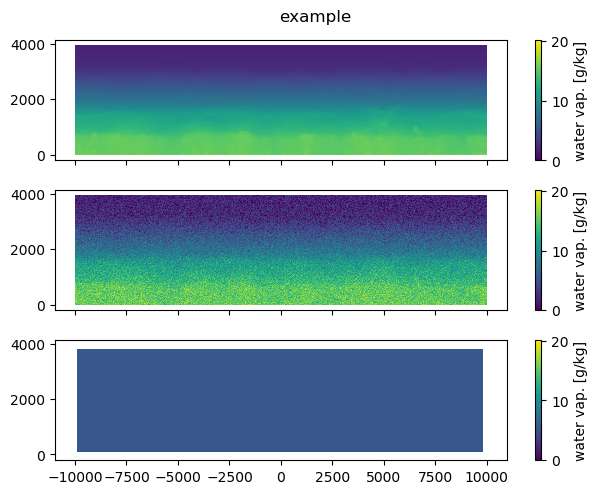

PyObject Text(0.5, 1.02, 'example')

In [53]:
fig, axes = PyPlot.subplots(3, 1, sharex=true, sharey=true)
vmax = max(maximum(y), maximum(y_noisy), maximum(ŷ))
vmin = min(minimum(y), minimum(y_noisy), minimum(ŷ))


for (ax, data_, x_, z_) in zip(axes, [y, y_noisy, ŷ], [x_grid, x_grid, x_grid_conv], [z_grid, z_grid, z_grid_conv])
    p = ax.pcolormesh(x_, z_, data_, vmax=vmax, vmin=0.0)
    cb = PyPlot.colorbar(p1, ax=ax)
    cb.set_label("water vap. [g/kg]")
end

PyPlot.tight_layout()
PyPlot.suptitle("example", y=1.02)
#PyPlot.savefig()

In [ ]:
p1 = Plots.heatmap(x_grid, z_grid, y, title="y (from LES)", ylabel="altitude [m]", colorbar_title="water vap. [g/kg]")
p2 = Plots.heatmap(x_grid, z_grid, y_noisy, title="x (added noise)", ylabel="altitude [m]", colorbar_title="water vap. [g/kg]")
p3 = Plots.heatmap(x_grid_conv, z_grid_conv, ŷ, title="ŷ (NN prediction)", ylabel="altitude [m]", xlabel="horz. dist. [m]", colorbar_title="water vap. [g/kg]")
figure = Plots.plot(p1, p2, p3, layout=(3,1); size=(1200, 800))
